# CMP466 Project: Coral Reef Bleaching Classification
*       Dataset Name: A Global Coral-Bleaching Database, 1980-2020

*       I. Data Cleaning and Preprocessing
*       II. Machine Learning Methods
*               a. Decision Tree Classifier

In [141]:
#ALL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from collections import Counter

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



### I. Cleaning & Preprocessing the Dataset

In [60]:
dtype_options = {
    'Distance_to_Shore' : 'object',
    'Turbidity' : 'object',
    'Percent_Bleaching' : 'object'
}  # these features contain values that are either numerical or strings, so we need to change it to Object before proceeding

myfilepath = r'global_bleaching_environmental.csv'

In [61]:
df = pd.read_csv(myfilepath, dtype = dtype_options)

In [62]:
#display(df)

In [63]:
#df.describe()       # data summary (original dataset without cleaning)

In [64]:
#df.info()           # non-null count is equal to the number of records because the empty cells are labelled as 'nd', not as null or NaN (doesn't recognize it)

In [65]:
#df.nunique()           # returns an int value representing the number of unique values (applied to all columns)

In [66]:
#df.isnull()         # we're getting all 'False' because it doesn't recognize 'nd' as null

#### Identifying Columns/Records with 'nd' 

In [67]:
 # first, drop any record with no target

df_new1 = df[df['Percent_Bleaching'] != 'nd']
df_new1['Percent_Bleaching'].value_counts()

Percent_Bleaching
0        16629
5.5       1184
75         914
0.25       882
1          705
         ...  
6.13         1
6.11         1
6.09         1
5.98         1
97.22        1
Name: count, Length: 2240, dtype: int64

In [68]:
df_new1.shape            # now, the dataset is composed of 34515 records with the number of columns unchanged

(34515, 62)

In [69]:
# identify any columns with 'nd' occupying more than 10% of its rows

cols1 = df_new1.columns.values   # cols contains the columns names as a list
cols1_to_drop = []               # store columns to drop in this list
for c in cols1:                  # iterate through each value belonging to the columns and search for those columns with more than 10% of its rows as 'nd' 
    ndCount = (df_new1[c] == 'nd').sum()         
    if ndCount > 0.1 * df_new1.shape[0]:
        cols1_to_drop.append(c)
print(cols1_to_drop)            # Output: ['Reef_ID', 'Site_Name', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments']
                                # To check the values of Bleaching_Level --> df_new['Bleaching_Level'].value_counts()

['Reef_ID', 'Site_Name', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments']


In [70]:
cols1_to_drop.extend(['SSTA_Mean', 'Data_Source', 'Country_Name', 'State_Island_Province_Name', 'City_Town_Name', 'Date', 'Date_Day', 'Date_Month', 'Date_Year', 'Site_ID'])
len(cols1_to_drop)    # we added irrelevant or completely zero columns to remove as well

18

In [71]:
# now, drop the identified columns/features

df_new2 = df_new1.drop(columns = cols1_to_drop)   
#display(df_new2)

In [72]:
df_new2.shape                   # now, the dataset is composed of 34515 records and 54 columns (including target)  

(34515, 44)

In [73]:
df_new3 = df_new2.replace('nd', np.nan).dropna()       # remove any records with 'nd'
#df_new3

In [74]:
#df_new3.replace('nd', np.nan).isnull().sum()      # checking that all columns now have no null values

#### Checking Collinearity

TODO:
* Go over all features and see which ones have mixed data types (find a way to check data types for individual vals of the column)
* We can follow the paper, where any features with a collinearity coefficient higher than 0.8 are dropped
*       Some features mentioned in the paper are TSA_DHW and wind speed
* Features Highly Correlated with Coral Bleaching (As Indicated in Paper):
*       SST, SSTA, Coral Depth, Longitude, Latitude      


In [75]:
#df_new3.info()          # we want to check the data types for each column
                        # it seems that many columns are classified as 'object', where if you check the type of each value, it will give you string even if the type is float!

In [76]:
# identify all columns of data type 'object'
object_columns = df_new3.select_dtypes(include = ['object'])
#object_columns.info()

In [77]:
notFloat_cols = ['Ocean_Name', 'Realm_Name', 'Ecoregion_Name', 'Exposure']
float_cols = [col for col in object_columns if col not in notFloat_cols]
df_new4 = df_new3
df_new4[float_cols] = df_new3[float_cols].astype(float)
#df_new4.info()

In [78]:
df_new4[notFloat_cols] = df_new4[notFloat_cols].astype('string')
#df_new4.info()

In [79]:
#df_new4.corr(numeric_only = True)      # correlation matrix

In [80]:
#sns.heatmap(df_new4.corr(numeric_only = True), cmap = 'RdBu')

#### Next Step is to Encode Features
*     Exposure -> ordinal (integer encoding) 
*           df_new4['Exposure'].nunique() -> 3
*     Ocean Name -> nominal (one-hot encoding)
*     Other Names -> nominal (one-hot encoding)


In [81]:
df_new5 = df_new4

In [82]:
ordinal_encoder = OrdinalEncoder()
df_new5[['Exposure']] = ordinal_encoder.fit_transform(df_new5[['Exposure']])        # for reference: 0.0 is Exposed, 1.0 is Sheltered, 2.0 is Sometimes

##### One-Hot Encoding

One way to do it:

In [83]:
#oneHot_encoder = OneHotEncoder()
#encodedCols = ['Ocean_Name', 'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name', 'City_Town_Name']       # I'm assuming no need for 'Data_Source'???   

#oneHot_encoder_result = oneHot_encoder.fit_transform(df_new5[encodedCols])
#df_new5 = df_new5.join( pd.DataFrame( oneHot_encoder_result.toarray(), columns = oneHot_encoder.categories_ ))    # DataFrame consists of the data and the columns
                                                                                                                  # Converting the resultant OHE matrix to an array and then to a dataframe
                                                                                                                  # oneHot_encoder.feature_names_in_ -> gives you only the feature name!!
                                                                                                                  # we want the categories -> onehot_enc.categories_
# ^^^ last line gives this error: ValueError: all arrays must be same length

Our method

In [84]:
encodedCols = ['Ocean_Name', 'Ecoregion_Name', 'Realm_Name']       # 5 cols for Ocean, 8 for Realm, 100 for Ecoregeion
df_new6 = pd.get_dummies(df_new5, columns=encodedCols).astype(int)
#display(df_new6)

##### So far (as of df_new6) we have 32675 records, and 154 columns
42 features total + 1 label column\
113 of the cols are OHE for 3 features\
during model training we will feed 152 features (removing the sample ID)

##### Discretizing Target Percent Bleaching

In [85]:
df_new6['Percent_Bleaching'].value_counts()

Percent_Bleaching
0     19111
1      2065
5      1563
2      1167
3       721
      ...  
94       10
79        9
97        7
84        6
99        2
Name: count, Length: 101, dtype: int64

# Graph Discretized Bins vs Accuracy

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.


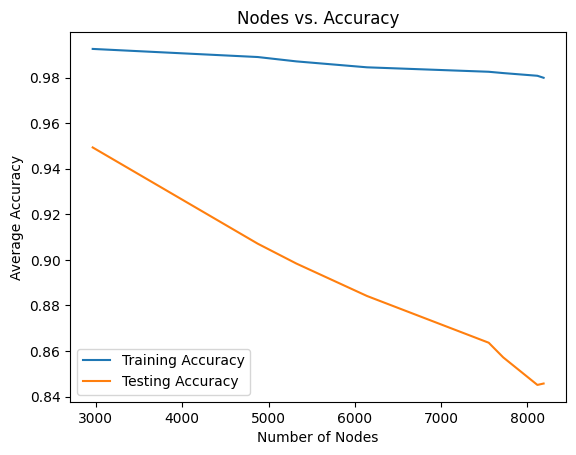

In [87]:
train_acc = []
test_acc = []
node_count = []

binsList = list(range(2,10))
for n in binsList:
    kbd = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_new7 = df_new6 # make a copy

# The below is for when we want to mask the zeros
#    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#    mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#    discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#    df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1

    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching']
    df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']])
    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]
   
    y = df_new7['Percent_Bleaching_Discretized'].to_numpy()
    X = df_new7.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    coralDT = DecisionTreeClassifier() #create the tree
    coralDT.fit(X_train, y_train) #train the tree
    train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
    test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
    node_count.append(coralDT.tree_.node_count) #retrieve the nodes used

plt.plot(node_count, train_acc, label='Training Accuracy')
plt.plot(node_count, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Average Accuracy')
plt.title('Nodes vs. Accuracy')
plt.legend()
plt.show()


#    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.


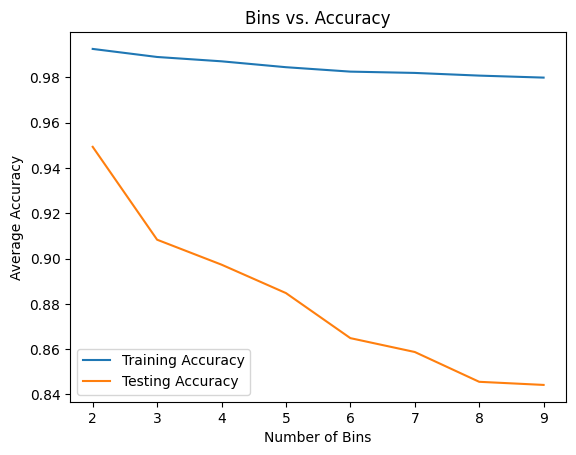

In [88]:
train_acc = []
test_acc = []

binsList = list(range(2,10))
for n in binsList:
    kbd = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_new7 = df_new6 # make a copy

# The below is for when we want to mask the zeros
#    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#    mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#    discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#    df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1

    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching']
    df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']])
    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]
   
    y = df_new7['Percent_Bleaching_Discretized'].to_numpy()
    X = df_new7.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    coralDT = DecisionTreeClassifier() #create the tree
    coralDT.fit(X_train, y_train) #train the tree
    train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
    test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming

plt.plot(binsList, train_acc, label='Training Accuracy')
plt.plot(binsList, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Bins')
plt.ylabel('Average Accuracy')
plt.title('Bins vs. Accuracy')
plt.legend()
plt.show()


# Discretize

In [92]:
kbd = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')   # K-means Discretization
                                                                        # Test to see which is the optimal number of bins
df_new7 = df_new6 # make a copy

df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later

df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']]) # discretize the non-zeros
df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Percent_Bleaching,Percent_Bleaching_Discretized
0,50,1.0
1,50,1.0
2,50,1.0
3,50,1.0
4,50,1.0
...,...,...
35040,100,1.0
35041,100,1.0
35042,100,1.0
35043,100,1.0


In [93]:
df_new7['Percent_Bleaching_Discretized'].value_counts()

Percent_Bleaching_Discretized
0.0    29865
1.0     2810
Name: count, dtype: int64

In [94]:
kbd.bin_edges_

array([array([  0.       ,  31.5591283, 100.       ])], dtype=object)

# Undersampling

In [95]:
rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")

df_new10 = df_new7

y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0.0, 2810), (1.0, 2810)]


Not using the following:

Undersampling Majority to be twice as large as minority

In [96]:
# rus = RandomUnderSampler(random_state=0, sampling_strategy=0.3)

# df_new10 = df_new7

# y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

# X_undersampled, y_undersampled = rus.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

Oversampling Minority to be same as majority

In [97]:
# smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
# X_resampled, y_resampled = smote_enn.fit_resample(X_undersampled, y_undersampled)
# print(sorted(Counter(y_resampled).items()))

In [98]:
X_resampled.shape

(5620, 152)

In [99]:
y_resampled.shape

(5620,)

# Combination of Under and Over Sampling

Decided not to use

In [100]:
#smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
#df_new10 = df_new7
#y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
#X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
#X_resampled, y_resampled = smote_enn.fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

In [101]:
#smote_tomek = SMOTETomek(random_state=0)
#df_new10 = df_new7
#y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
#X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
#X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

# Decision Tree after undersampling

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

coral_DT = DecisionTreeClassifier()
coral_DT.fit(X_train, y_train)
print(coral_DT.score(X_train, y_train))
print(coral_DT.score(X_test, y_test))

0.9959964412811388
0.8576512455516014


In [103]:
# train_acc = []
# test_acc = []
# node_count = []

# df_new10 = df_new7
# y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

# for n in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#     rus = RandomUnderSampler(random_state=0, sampling_strategy=n)
#     X_undersampled, y_undersampled = rus.fit_resample(X, y)
#     smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
#     X_resampled, y_resampled = smote_enn.fit_resample(X_undersampled, y_undersampled)
#     X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)
#     coral_DT = DecisionTreeClassifier()
#     coral_DT.fit(X_train, y_train)
#     train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
#     test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
#     node_count.append(coralDT.tree_.node_count) #retrieve the nodes used

# plt.plot(node_count, train_acc, label='Training Accuracy')
# plt.plot(node_count, test_acc, label='Testing Accuracy')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Average Accuracy')
# plt.title('Nodes vs. Accuracy')
# plt.legend()
# plt.show()


### Feature Selection

In [104]:
X_new_FS = SelectPercentile(f_classif, percentile = 50).fit_transform(X_resampled, y_resampled)

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 46  50  58  63  75  84  87 107 127 139 143] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [106]:
X_new_FS.shape

(5620, 76)

# Scaling

In [108]:
# This one is slightly better than MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_new_rescaled = scaler.fit_transform (X_new_FS) 
print(X_new_rescaled)

[[ 1.21029671  0.37613537 -0.61724505 ... -1.10952425 -0.05343317
   3.31791305]
 [ 1.00081081 -0.76585311  0.32507541 ...  0.90128719 -0.05343317
  -0.30139428]
 [ 1.21029671  0.37613537 -0.61724505 ... -1.10952425 -0.05343317
   3.31791305]
 ...
 [-1.65267725  0.50636213 -2.03072574 ... -1.10952425 -0.05343317
   3.31791305]
 [ 0.93098217 -0.77587056  0.67844558 ...  0.90128719 -0.05343317
  -0.30139428]
 [ 0.93098217 -0.76585311  1.14960581 ...  0.90128719 -0.05343317
  -0.30139428]]


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_new_rescaled, y_resampled, test_size=0.20, random_state=42)

coral_DT = DecisionTreeClassifier()
coral_DT.fit(X_train, y_train)
print(coral_DT.score(X_train, y_train))
print(coral_DT.score(X_test, y_test))

0.989991103202847
0.858540925266904


## PCA (Principle Component Analysis)

Decided to not use

In [58]:
# from sklearn.decomposition import PCA 

# for n in range(2, X_new_rescaled.shape[1]):
#     pca = PCA(n_components=n) 
#     pca.fit(X_new_rescaled) 
#     #print(pca.explained_variance_ratio_) 
#     #print(pca.singular_values_)

# plt.plot(node_count, train_acc, label='Training Accuracy')
# plt.plot(node_count, test_acc, label='Testing Accuracy')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Average Accuracy')
# plt.title('Nodes vs. Accuracy')
# plt.legend()
# plt.show()
# #print(pca.explained_variance_ratio_.sum())

In [6]:
# pca = PCA()
# pca.fit(X_new_rescaled)

# explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# cumulative_explained_variance = explained_variance_ratio.cumsum()
# num_components = (cumulative_explained_variance < 0.95).sum() + 1

# pca = PCA(n_components=num_components)
# X_pca = pca.fit_transform(X_new_rescaled)

# End of Preprocessing 

### II. Machine Learning Methods
#### a. Decision Tree Classifier

In [70]:
#X_train, X_test, y_train, y_test = train_test_split(X_new_rescaled, y_resampled, test_size=0.20, random_state=42)

#### Decision Tree with no parameters

In [177]:
coral_DT = DecisionTreeClassifier()
coral_DT.fit(X_train, y_train)
print(coral_DT.score(X_train, y_train))
print(coral_DT.score(X_test, y_test))

0.989991103202847
0.8558718861209964


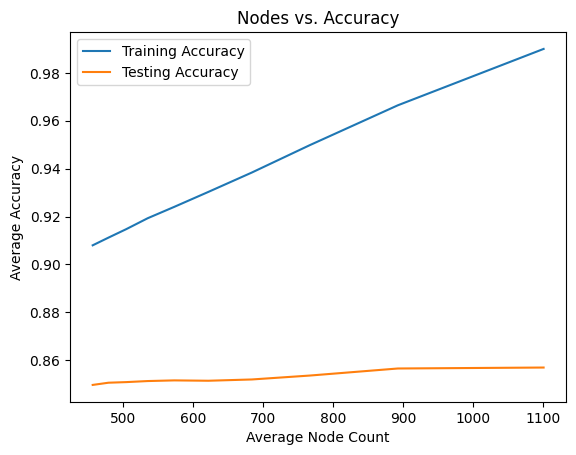

In [179]:
import matplotlib.pyplot as plt

train_acc = []
test_acc = []
node_count = []
avg_train_acc = []
avg_test_acc = []
avg_node_count = []

for i in range(2,100,10):
    for j in range(10):
        coralDT = DecisionTreeClassifier(min_samples_split=i) #create the tree
        coralDT.fit(X_train, y_train) #train the tree
        train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
        test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
        node_count.append(coralDT.tree_.node_count) #retrieve the nodes used
    #calculate the avg training, test accuracies, and node count
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))
    avg_node_count.append(sum(node_count) / len(node_count))

plt.plot(avg_node_count, avg_train_acc, label='Training Accuracy')
plt.plot(avg_node_count, avg_test_acc, label='Testing Accuracy')
plt.xlabel('Average Node Count')
plt.ylabel('Average Accuracy')
plt.title('Nodes vs. Accuracy')
plt.legend()
plt.show()

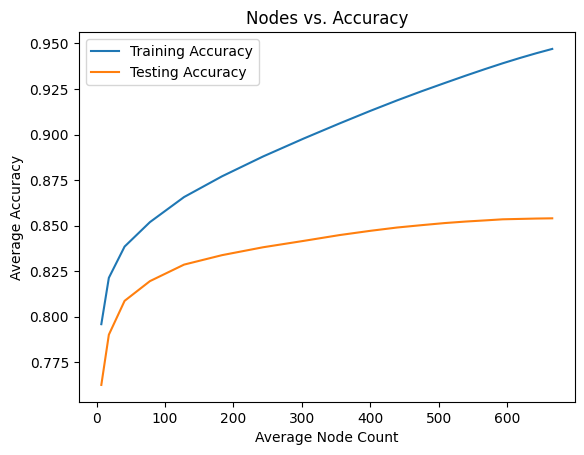

In [180]:
import matplotlib.pyplot as plt

train_acc = []
test_acc = []
node_count = []
avg_train_acc = []
avg_test_acc = []
avg_node_count = []
parameter_val = []

for i in range(2,40,2):
    for j in range(10):
        coralDT = DecisionTreeClassifier(max_depth=i) #create the tree
        coralDT.fit(X_train, y_train) #train the tree
        train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
        test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
        node_count.append(coralDT.tree_.node_count) #retrieve the nodes used
    #calculate the avg training, test accuracies, and node count
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))
    avg_node_count.append(sum(node_count) / len(node_count))

plt.plot(avg_node_count, avg_train_acc, label='Training Accuracy')
plt.plot(avg_node_count, avg_test_acc, label='Testing Accuracy')
plt.xlabel('Average Node Count')
plt.ylabel('Average Accuracy')
plt.title('Nodes vs. Accuracy')
plt.legend()
plt.show()

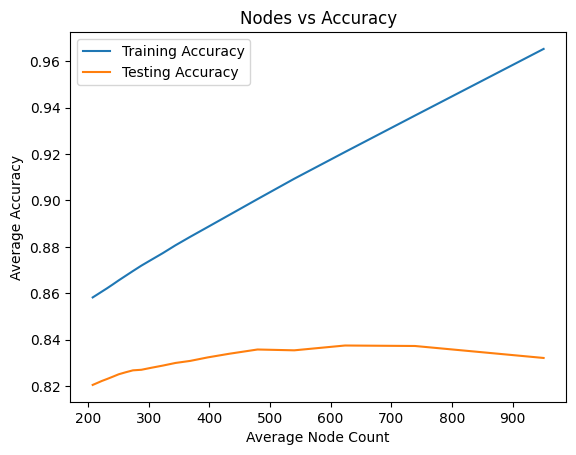

In [181]:
train_acc = []
test_acc = []
node_count = []
avg_train_acc = []
avg_test_acc = []
avg_node_count = []

for i in range(1,100,5):
    for j in range(10):
        coralDT = DecisionTreeClassifier(min_samples_leaf=i) #create the tree
        coralDT.fit(X_train, y_train) #train the tree
        train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
        test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
        node_count.append(coralDT.tree_.node_count) #retrieve the nodes used
    #calculate the avg training, test accuracies, and node count
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))
    avg_node_count.append(sum(node_count) / len(node_count))

plt.plot(avg_node_count, avg_train_acc, label='Training Accuracy')
plt.plot(avg_node_count, avg_test_acc, label='Testing Accuracy')
plt.xlabel('Average Node Count')
plt.ylabel('Average Accuracy')
plt.title('Nodes vs Accuracy')
plt.legend()
plt.show()

In [193]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

max_dep = list(range(2,40,5))
max_dep = max_dep + [None]

param_grid = {
    'max_depth': max_dep,       
    'min_samples_split': list(range(2,101, 5)),
    'min_samples_leaf': list(range(1,101, 5))
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 7, 12, 17, 22, 27, 32, 37, None],
                         'min_samples_leaf': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                              46, 51, 56, 61, 66, 71, 76, 81,
                                              86, 91, 96],
                         'min_samples_split': [2, 7, 12, 17, 22, 27, 32, 37, 42,
                                               47, 52, 57, 62, 67, 72, 77, 82,
                                               87, 92, 97]})

### TODO: Need to do undersampling and figure out how to do F1 score

In [194]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=22)

In [195]:
grid_search.best_score_

0.8589852923000866

In [196]:
grid_search.best_params_

{'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [197]:
coralDT = DecisionTreeClassifier()
coralDT.fit(X_train, y_train)
print(coralDT.score(X_train, y_train))
print(coralDT.score(X_test, y_test))

0.989991103202847
0.854982206405694


In [198]:
coralDT = DecisionTreeClassifier(max_depth=22)
coralDT.fit(X_train, y_train)
print(coralDT.score(X_train, y_train))
print(coralDT.score(X_test, y_test))

0.9766459074733096
0.8620996441281139


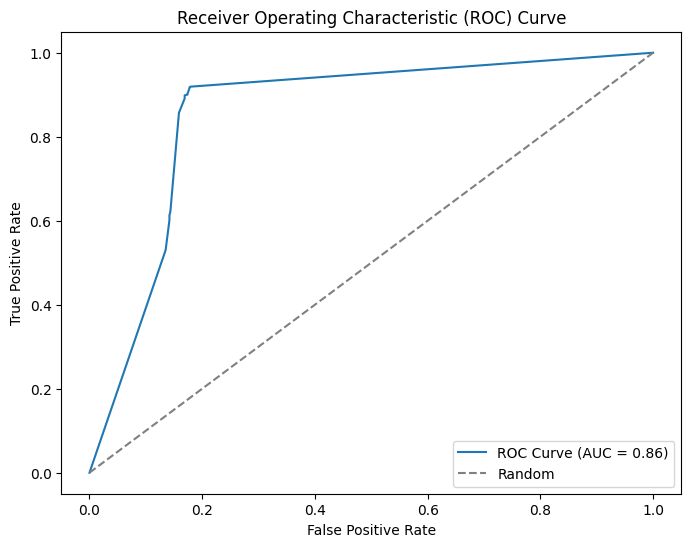

Accuracy: 0.8620996441281139
F1 Score: 0.8609865470852017
Precision: 0.823327615780446
Recall: 0.9022556390977443
AUC: 0.8577334383255435
Confusion Matrix:
[[489 103]
 [ 52 480]]


In [199]:
y_pred = coralDT.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

if hasattr(coralDT, 'predict_proba'):
    prob_positive_class = coralDT.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, prob_positive_class)
else:
    roc_auc = None

conf_matrix = confusion_matrix(y_test, y_pred)

if roc_auc is not None:
    fpr, tpr, thresholds = roc_curve(y_test, prob_positive_class)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
if roc_auc is not None:
    print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)


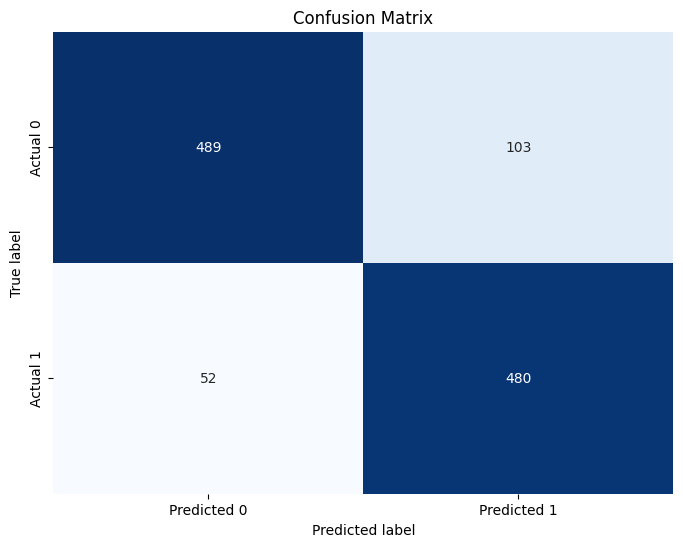

In [200]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


# SVM

## Linear

In [122]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],       
    'dual': ['auto', True],
    'multi_class': ['ovr', 'crammer_singer'],
    'class_weight': ['balanced', None],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],

}

coral_LinearSVC = LinearSVC()

grid_search = GridSearchCV(coral_LinearSVC, param_grid, cv=5)
grid_search.fit(X_train, y_train)

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', None],
                         'dual': ['auto', True],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']})

In [123]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'C': 10, 'class_weight': None, 'dual': True, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.846085032752441
LinearSVC(C=10, dual=True, loss='hinge', multi_class='crammer_singer')


c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

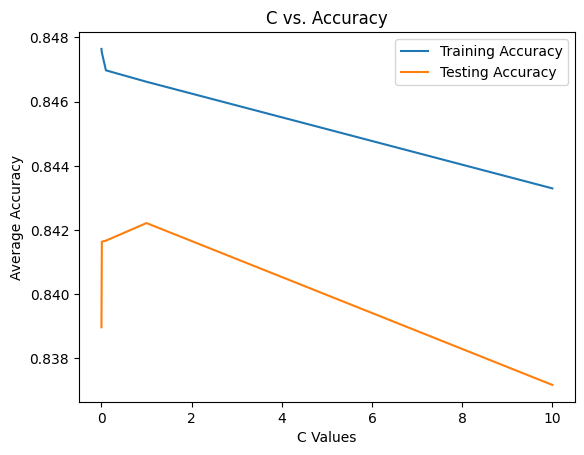

In [125]:
train_acc = []
test_acc = []
avg_train_acc = []
avg_test_acc = []

C_list = [0.001, 0.01, 0.1, 1, 10]

for c in C_list:
    for j in range(10):
        coral_LinearSVC = LinearSVC(C=c)
        coral_LinearSVC.fit(X_train, y_train)
        train_acc.append(coral_LinearSVC.score(X_train, y_train))
        test_acc.append(coral_LinearSVC.score(X_test, y_test))
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))

plt.plot(C_list, avg_train_acc, label='Training Accuracy')
plt.plot(C_list, avg_test_acc, label='Testing Accuracy')
plt.xlabel('C Values')
plt.ylabel('Average Accuracy')
plt.title('C vs. Accuracy')
plt.legend()
plt.show()

In [145]:
coral_LinearSVC = LinearSVC(C=10, dual=True, loss='hinge', multi_class='crammer_singer')
coral_LinearSVC.fit(X_train, y_train)
print(coral_LinearSVC.score(X_train, y_train))
print(coral_LinearSVC.score(X_test, y_test))

0.8505338078291815
0.8407473309608541


c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [146]:
coral_LinearSVC = LinearSVC(C=1, dual=True, loss='hinge', multi_class='crammer_singer')
coral_LinearSVC.fit(X_train, y_train)
print(coral_LinearSVC.score(X_train, y_train))
print(coral_LinearSVC.score(X_test, y_test))

0.8498665480427047
0.844306049822064


c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [147]:
coral_LinearSVC = LinearSVC()
coral_LinearSVC.fit(X_train, y_train)
print(coral_LinearSVC.score(X_train, y_train))
print(coral_LinearSVC.score(X_test, y_test))

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8460854092526691
0.8487544483985765


c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


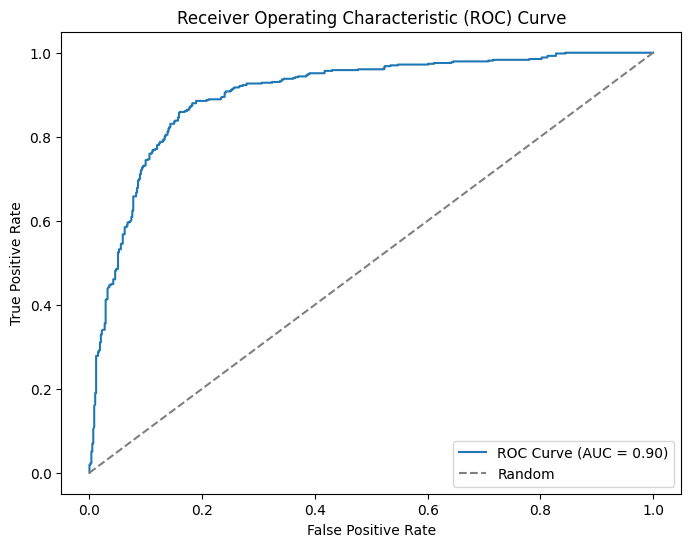

Accuracy: 0.8487544483985765
F1 Score: 0.8428835489833642
Precision: 0.8290909090909091
Recall: 0.8571428571428571
AUC: 0.902787479678927
Confusion Matrix:
[[498  94]
 [ 76 456]]


In [148]:
y_pred = coral_LinearSVC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, coral_LinearSVC.decision_function(X_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, coral_LinearSVC.decision_function(X_test))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

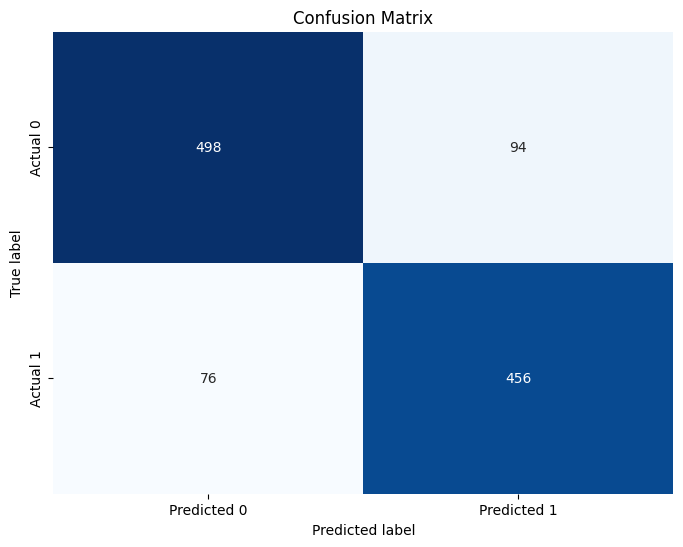

In [149]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


Same best model but no dimensionality reduction

In [204]:
scaler = StandardScaler()
X_rescaled_nd = scaler.fit_transform (X_resampled) 
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_rescaled_nd, y_resampled, test_size=0.20, random_state=42)

coral_LinearSVC = LinearSVC()
coral_LinearSVC.fit(X_train_nd, y_train_nd)
print(coral_LinearSVC.score(X_train_nd, y_train_nd))
print(coral_LinearSVC.score(X_test_nd, y_test_nd))

c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8594306049822064
0.849644128113879


c:\Users\linas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [210]:
y_pred_nd = coral_LinearSVC.predict(X_test_nd)

accuracy = accuracy_score(y_test_nd, y_pred_nd)
f1 = f1_score(y_test_nd, y_pred_nd)
precision = precision_score(y_test_nd, y_pred_nd)
recall = recall_score(y_test_nd, y_pred_nd)
roc_auc = roc_auc_score(y_test_nd, coral_LinearSVC.decision_function(X_test_nd))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_nd, y_pred_nd)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.849644128113879
F1 Score: 0.8442396313364056
Precision: 0.8282097649186256
Recall: 0.8609022556390977
AUC: 0.9030002159114001
Confusion Matrix:
[[497  95]
 [ 74 458]]


## Polynomial SVC

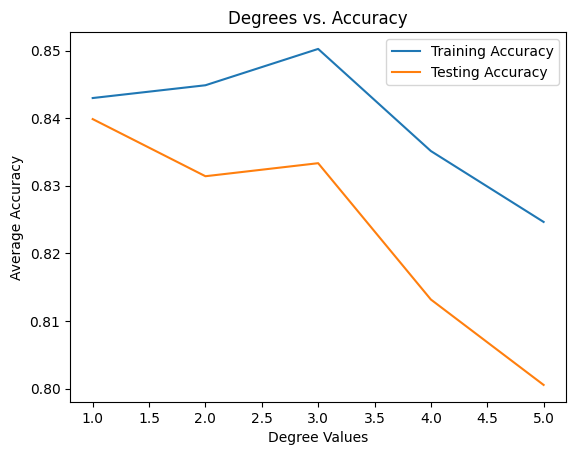

In [129]:
from sklearn.svm import SVC

train_acc = []
test_acc = []
avg_train_acc = []
avg_test_acc = []

degree_list = [1, 2, 3, 4, 5]

for d in degree_list:
    for j in range(10):
        coral_PolySVC = SVC(kernel='poly',degree=d)
        coral_PolySVC.fit(X_train, y_train)
        train_acc.append(coral_PolySVC.score(X_train, y_train))
        test_acc.append(coral_PolySVC.score(X_test, y_test))
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))

plt.plot(degree_list, avg_train_acc, label='Training Accuracy')
plt.plot(degree_list, avg_test_acc, label='Testing Accuracy')
plt.xlabel('Degree Values')
plt.ylabel('Average Accuracy')
plt.title('Degrees vs. Accuracy')
plt.legend()
plt.show()

In [133]:
coral_PolySVC = SVC(kernel='poly',degree=3)
coral_PolySVC.fit(X_train, y_train)

print(coral_PolySVC.score(X_train, y_train))
print(coral_PolySVC.score(X_test, y_test))

0.8609875444839857
0.8371886120996441


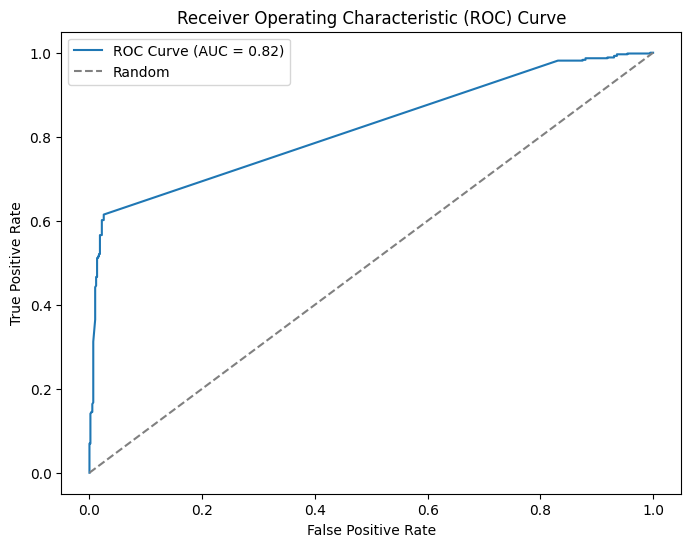

Accuracy: 0.751779359430605
F1 Score: 0.651685393258427
Precision: 0.9702602230483272
Recall: 0.4906015037593985
AUC: 0.8202267704734809
Confusion Matrix:
[[584   8]
 [271 261]]


In [139]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

y_pred = coral_PolySVC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, coral_PolySVC.decision_function(X_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, coral_PolySVC.decision_function(X_test))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)


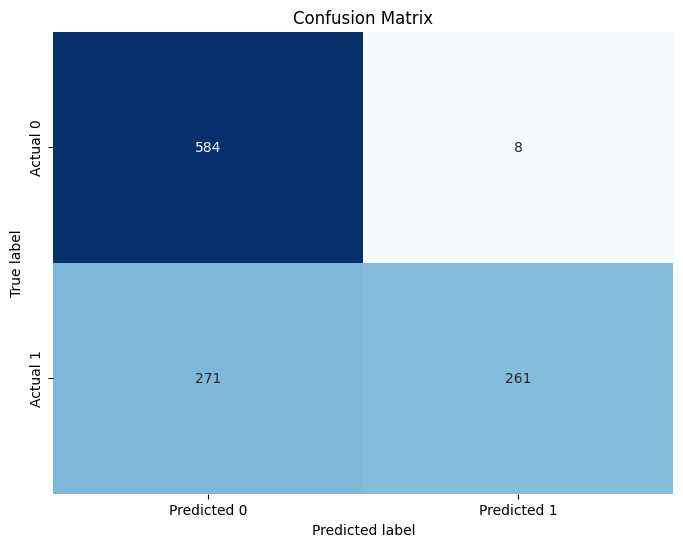

In [140]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


Same best model but No Dimensionality reduction

In [205]:
coral_PolySVC = SVC(kernel='poly',degree=3)
coral_PolySVC.fit(X_train_nd, y_train_nd)
print(coral_PolySVC.score(X_train_nd, y_train_nd))
print(coral_PolySVC.score(X_test_nd, y_test_nd))

0.8067170818505338
0.7677935943060499


In [211]:
y_pred_nd = coral_PolySVC.predict(X_test_nd)

accuracy = accuracy_score(y_test_nd, y_pred_nd)
f1 = f1_score(y_test_nd, y_pred_nd)
precision = precision_score(y_test_nd, y_pred_nd)
recall = recall_score(y_test_nd, y_pred_nd)
roc_auc = roc_auc_score(y_test_nd, coral_PolySVC.decision_function(X_test_nd))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_nd, y_pred_nd)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7677935943060499
F1 Score: 0.7763496143958868
Precision: 0.7133858267716535
Recall: 0.8515037593984962
AUC: 0.8833681543385492
Confusion Matrix:
[[410 182]
 [ 79 453]]


## RBF SVC

In [163]:
train_acc = []
test_acc = []
avg_train_acc = []
avg_test_acc = []

C_list = [0.001, 0.01, 0.1, 1, 10, 20, 100]

for c in C_list:
    for j in range(10):
        coral_RBF_SVC = SVC(kernel='rbf', C=c) 
        coral_RBF_SVC.fit(X_train, y_train)
        train_acc.append(coral_RBF_SVC.score(X_train, y_train))
        test_acc.append(coral_RBF_SVC.score(X_test, y_test))
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))


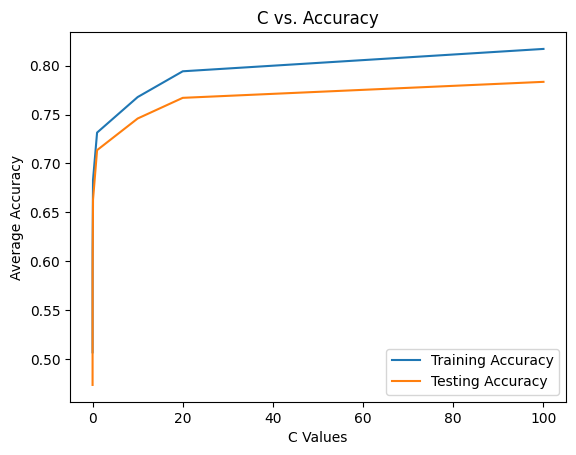

In [164]:
plt.plot(C_list, avg_train_acc, label='Training Accuracy')
plt.plot(C_list, avg_test_acc, label='Testing Accuracy')
plt.xlabel('C Values')
plt.ylabel('Average Accuracy')
plt.title('C vs. Accuracy')
plt.legend()
plt.show()


In [165]:
train_acc = []
test_acc = []
avg_train_acc = []
avg_test_acc = []

Gamma_list = [0.001, 0.01, 0.1, 1, 10, 20, 100]

for g in Gamma_list:
    for j in range(10):
        coral_RBF_SVC = SVC(kernel='rbf', gamma=g)
        coral_RBF_SVC.fit(X_train, y_train)
        train_acc.append(coral_RBF_SVC.score(X_train, y_train))
        test_acc.append(coral_RBF_SVC.score(X_test, y_test))
    avg_train_acc.append(sum(train_acc)/len(train_acc))
    avg_test_acc.append(sum(test_acc)/len(train_acc))

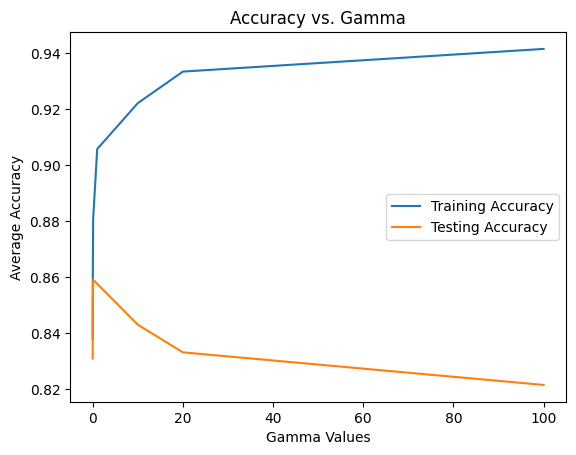

In [166]:
plt.plot(Gamma_list, avg_train_acc, label='Training Accuracy')
plt.plot(Gamma_list, avg_test_acc, label='Testing Accuracy')
plt.xlabel('Gamma Values')
plt.ylabel('Average Accuracy')
plt.title('Accuracy vs. Gamma')
plt.legend()
plt.show()

In [167]:
coral_RBF_SVC = SVC(kernel='rbf', C=1, gamma = 0.1) 
coral_RBF_SVC.fit(X_train, y_train)
print(coral_RBF_SVC.score(X_train, y_train))
print(coral_RBF_SVC.score(X_test, y_test))

0.9317170818505338
0.8816725978647687


In [168]:
coral_RBF_SVC = SVC(kernel='rbf', C=1, gamma = 1) 
coral_RBF_SVC.fit(X_train, y_train)
print(coral_RBF_SVC.score(X_train, y_train))
print(coral_RBF_SVC.score(X_test, y_test))

0.9808718861209964
0.853202846975089


In [169]:
coral_RBF_SVC = SVC(kernel='rbf', C=20, gamma = 0.1) 
coral_RBF_SVC.fit(X_train, y_train)
print(coral_RBF_SVC.score(X_train, y_train))
print(coral_RBF_SVC.score(X_test, y_test))

0.979314946619217
0.8932384341637011


In [176]:
coral_RBF_SVC = SVC(kernel='rbf', C=20, gamma = 1) 
coral_RBF_SVC.fit(X_train, y_train)
print(coral_RBF_SVC.score(X_train, y_train))
print(coral_RBF_SVC.score(X_test, y_test))

0.988211743772242
0.8540925266903915


In [175]:
coral_RBF_SVC = SVC(kernel='rbf', C=10, gamma = 1) 
coral_RBF_SVC.fit(X_train, y_train)
print(coral_RBF_SVC.score(X_train, y_train))
print(coral_RBF_SVC.score(X_test, y_test))

0.9866548042704626
0.8558718861209964


best model:

In [170]:
coral_RBF_SVC = SVC(kernel='rbf', C=10, gamma = 0.1) 
coral_RBF_SVC.fit(X_train, y_train)
print(coral_RBF_SVC.score(X_train, y_train))
print(coral_RBF_SVC.score(X_test, y_test))

0.972864768683274
0.8994661921708185


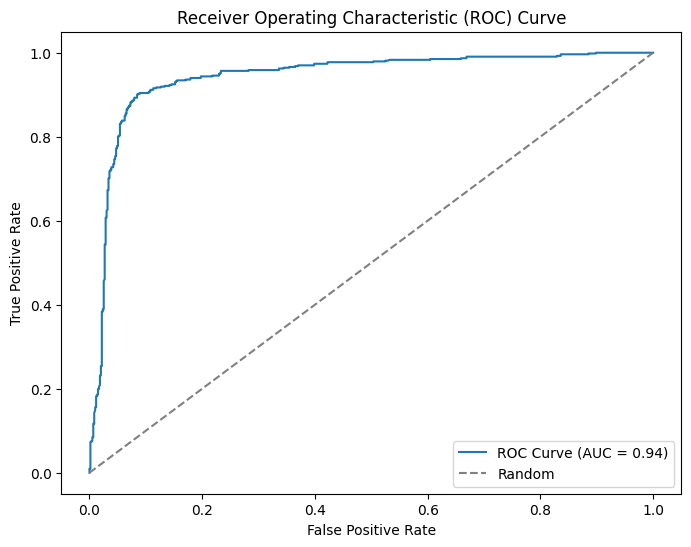

Accuracy: 0.8994661921708185
F1 Score: 0.8956602031394275
Precision: 0.8802177858439202
Recall: 0.9116541353383458
AUC: 0.9424484987807357
Confusion Matrix:
[[526  66]
 [ 47 485]]


In [171]:
y_pred = coral_RBF_SVC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, coral_RBF_SVC.decision_function(X_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, coral_RBF_SVC.decision_function(X_test))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

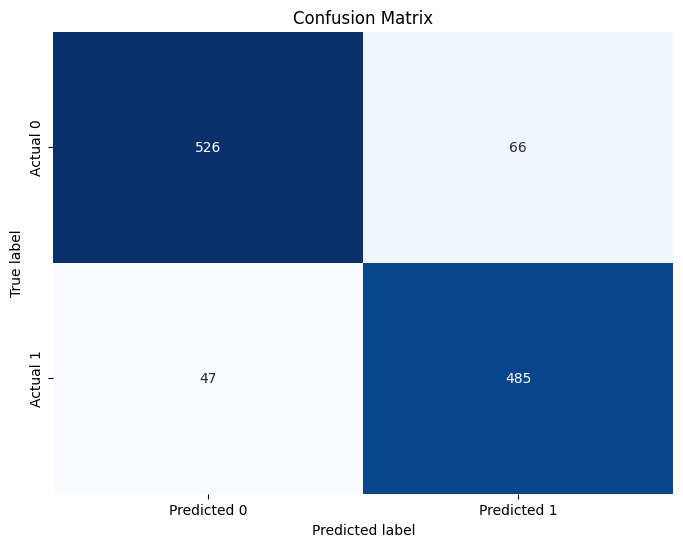

In [172]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


same model but without dimensionality reduction

In [206]:
coral_RBF_SVC = SVC(kernel='rbf', C=10, gamma = 0.1) 
coral_RBF_SVC.fit(X_train_nd, y_train_nd)
print(coral_RBF_SVC.score(X_train_nd, y_train_nd))
print(coral_RBF_SVC.score(X_test_nd, y_test_nd))

0.9766459074733096
0.900355871886121


In [212]:
y_pred_nd = coral_RBF_SVC.predict(X_test_nd)

accuracy = accuracy_score(y_test_nd, y_pred_nd)
f1 = f1_score(y_test_nd, y_pred_nd)
precision = precision_score(y_test_nd, y_pred_nd)
recall = recall_score(y_test_nd, y_pred_nd)
roc_auc = roc_auc_score(y_test_nd, coral_RBF_SVC.decision_function(X_test_nd))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_nd, y_pred_nd)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.900355871886121
F1 Score: 0.8953271028037383
Precision: 0.8903345724907064
Recall: 0.900375939849624
AUC: 0.9427818913838651
Confusion Matrix:
[[533  59]
 [ 53 479]]
